<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/u%2FJustinezgh%2FSNLE/notebooks/dev/SNLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet jax-cosmo numpyro dm-haiku==0.0.5 optax
!pip install --quiet git+https://github.com/Justinezgh/SBI-Diff-Simulator.git

     |████████████████████████████████| 283 kB 4.2 MB/s 
     |████████████████████████████████| 292 kB 60.1 MB/s 
     |████████████████████████████████| 287 kB 28.0 MB/s 
     |████████████████████████████████| 145 kB 75.8 MB/s 
     |████████████████████████████████| 85 kB 4.8 MB/s 
     |████████████████████████████████| 128 kB 3.9 MB/s 


In [ ]:
!pip install chainconsumer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.5 MB/s 
  Created wheel for chainconsumer: filename=ChainConsumer-0.34.0-py3-none-any.whl size=42779 sha256=2e2b5c73e39a1f3fd97054a503b1bd33a3887c79720566b935470ee4a1992a86
  Stored in directory: /root/.cache/pip/wheels/2d/e5/6c/c9b963aa8bafc25991c7ce2902ca81be7256746be0349137cf
Successfully built chainconsumer


In [ ]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

In [1]:
import logging
# Removing annoying TFP error message
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import argparse
import pickle
from functools import partial

import optax
import haiku as hk
import numpy as np
import jax
import jax.numpy as jnp
from numpyro.handlers import condition

import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions


from sbids.metrics.c2st import c2st
from sbids.tasks import (
  lotka_volterra, lotka_volterra_y_bijector, 
  lotka_volterra_theta_bijector, get_samples_and_scores
)
from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [3]:
from chainconsumer import ChainConsumer

In [4]:
# create model compressor 
class Compressor(hk.Module):

  def __call__(self, x):
    
    x = x/1000
    x = x[..., jnp.newaxis]

    net_x = hk.Conv1D(32, 3, 1)(x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Conv1D(64, 4, 2)(net_x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Conv1D(128, 3, 1)(net_x)
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Flatten()(net_x) 
    
    net_x = hk.Linear(32)(net_x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Linear(16)(net_x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Linear(4)(net_x) 

    return net_x.squeeze()

bijector_layers_compressor = [128] * 2

bijector_compressor = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers_compressor, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_compressor = partial(
  ConditionalRealNVP, 
  n_layers=3, 
  bijector_fn=bijector_compressor)


class Flow_nd_Compressor(hk.Module):
    def __call__(self, y):
        nvp = NF_compressor(4)(y)
        return tfd.TransformedDistribution(nvp,
                                           tfb.Chain([tfb.Invert(lotka_volterra_theta_bijector),
                                                      tfb.Scale(30.),
                                                      tfb.Shift(-0.5)]))

# compressor
compressor = hk.without_apply_rng(hk.transform(lambda x : Compressor()(x)))
# nf
nf = hk.without_apply_rng(hk.transform(lambda p,x : Flow_nd_Compressor()(x).log_prob(p).squeeze()))

a_file = open("/content/params_compressor4.pkl", "rb")
parameters_compressor = pickle.load(a_file)

# reg = compressor.apply(parameters_compressor,batch)
scale_reg = jnp.array([ 6.233213, 13.966835, 13.656771,  7.450791]) #(jnp.std(reg, axis =0)/0.04)
shift_reg = jnp.array([-0.4551523,  -0.48648357, -0.50399256, -0.4354317 ])#jnp.mean(reg/scale_reg, axis = 0)-0.5



In [5]:
## create model 
from functools import partial
bijector_layers = [128] * 2

bijector_npe = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_npe = partial(
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector_npe)


class SmoothNLE(hk.Module):
    def __call__(self, theta):
        transfo = tfb.Chain([tfb.Invert(lotka_volterra_theta_bijector),tfb.Scale(30.),tfb.Shift(-0.5)])
        net = transfo.inverse(theta)
        nvp = NF_npe(4)(net)
        return tfd.TransformedDistribution(nvp,
                                           tfb.Chain([tfb.Scale(scale_reg), tfb.Shift(shift_reg)]))

nvp_nd = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNLE()(theta).log_prob(y).squeeze()))

In [6]:
# create truth
seed_for_truth = 0
model = lotka_volterra
(log_probs, samples), scores = get_samples_and_scores(model, jax.random.PRNGKey(seed_for_truth), batch_size=1)
truth, observation = samples['theta'], samples['y'].reshape([-1,20],order='F')
reference_samples = jnp.load('/content/reference_sample_seed%d.npy' % seed_for_truth)

obs = compressor.apply(parameters_compressor, observation.reshape([1,20]))

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


In [ ]:
R = 3
seq = 1
start_grad = 1

batch_size=256
n_simulations=100
n_steps=2000
score_weight=0
initial_learning_rate=0.002

model_seed=0
rng_seq = hk.PRNGSequence(model_seed)

In [7]:
from tqdm import tqdm

In [36]:
def inference(sample,
              rounds, 
              score_weight, 
              n_simulations_in, 
              n_simulations_out,
              start_grad, 
              n_steps,
              batch_size, 
              params_nd):
  
  batch_loss = []
  c2st_metric = []
  sample_for_plot = []

  # create data train
  if rounds == 0 :
    thetas = None
  else :
    thetas = jnp.array(sample['thetas'][-n_simulations_in:])


  @jax.jit
  def get_batch(key, batch_size=n_simulations_in):
      model = lotka_volterra
      (log_probs, samples), scores = get_samples_and_scores(model, key, batch_size=batch_size, score_type='conditional', thetas = thetas)
      return samples['theta'], samples['y'].reshape([-1,20], order='F'), scores

  thetas, batch, score = get_batch(jax.random.PRNGKey(rounds)) 

  if jnp.isnan(score).any() == True:
    idx = jnp.where(jnp.isnan(score))[0]
    batch = jnp.delete(batch, idx, axis=0)
    thetas = jnp.delete(thetas, idx, axis=0)
    score = jnp.delete(score, idx, axis=0)

  if rounds == 0: 
    sample['thetas'] = thetas
    sample['batch'] = batch
    sample['score'] = score
    sample['round'] = jnp.repeat(rounds, len(score))
  else :
    sample['batch'] = np.concatenate((sample['batch'], batch))
    sample['score'] = np.concatenate((sample['score'], score))
    sample['round'] = np.concatenate((sample['round'], jnp.repeat(rounds, len(score))))

  # init optimizer
  scheduler = optax.exponential_decay(init_value=0.001, transition_steps=1000, decay_rate=0.9, end_value=0.00001)
  optimizer = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler), optax.scale(-1))
  opt_state = optimizer.init(params_nd)

  # define loss function and model update
  def loss_fn(params, weight, mu, batch, score):
    y = compressor.apply(parameters_compressor, batch)
    log_prob, out = jax.vmap(
      jax.value_and_grad(lambda theta, x: nvp_nd.apply(params, theta.reshape([1,4]), x.reshape([1,4])).squeeze())
      )(mu, y)
      
    return -jnp.mean(log_prob) +  jnp.mean(weight * jnp.sum((out - score)**2, axis=1)) 

  @jax.jit
  def update(params, opt_state, weight, mu, batch, score):
      """Single SGD update step."""
      loss, grads = jax.value_and_grad(loss_fn)(params, weight, mu, batch, score)
      updates, new_opt_state = optimizer.update(grads, opt_state, params)
      new_params = optax.apply_updates(params, updates)
    
      return loss, new_params, new_opt_state

  # train nf
  for step in tqdm(range(n_steps)): 

    inds = np.random.randint(0, len(sample['thetas']), batch_size) 
    
    inds_not_grad = jnp.where(sample['round'][inds] < start_grad)
    weight = np.repeat(score_weight, len(inds))
    weight[inds_not_grad] = 0

    l, params_nd, opt_state = update(params_nd, opt_state, weight, sample['thetas'][inds], sample['batch'][inds], sample['score'][inds])
    
    if jnp.isnan(l):
      break
    
    batch_loss.append(l)

  #mcmc
  print('start mcmc')
  import tensorflow as tf
  with tf.device('/CPU:0'):
    def unnormalized_log_prob(x):
            likelihood = nvp_nd.apply(params_nd, x.reshape([-1, 4]), obs.reshape([-1, 4])).squeeze()
            prior = tfd.LogNormal(loc=jnp.array([-0.125,-3,-0.125,-3]),
                                  scale=jnp.array([0.5, 0.5, 0.5, 0.5])).log_prob(x).sum()
            return likelihood + prior

        
    sample_nd = []
    j = 0

    nb_simulations_needed = 10000
    if n_simulations_out > 10000: 
      nb_simulations_needed = n_simulations_out

    while len(sample_nd) < nb_simulations_needed :
      num_results_size = 5 + j
      # Initialize the HMC transition kernel.
      num_results = int(nb_simulations_needed * num_results_size) 
      num_burnin_steps = int(4e3)
      adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
          tfp.mcmc.HamiltonianMonteCarlo(
              target_log_prob_fn=unnormalized_log_prob,
              num_leapfrog_steps=3,
              step_size=0.01),
          num_adaptation_steps=int(num_burnin_steps * 0.8))

      # Run the chain (with burn-in).
      @jax.jit
      def run_chain():
        samples, is_accepted = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            current_state=jnp.array(truth),
            kernel=adaptive_hmc,
            trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
            seed = jax.random.PRNGKey(j))
              
        return samples, is_accepted

      samples_hmc, is_accepted_hmc = run_chain()
      sample_nd = samples_hmc[is_accepted_hmc].reshape([-1,4])

      if num_results_size > 20:
        break

      j += 5

  # compute c2st metric
  if len(sample_nd) > 10000 : 
     inds = np.random.randint(0, len(sample_nd),  10000) 
     sample_nd_for_c2st = sample_nd[inds,...]
      
  if len(sample_nd) > n_simulations_out : 
       inds = np.random.randint(0, len(sample_nd),  n_simulations_out) 
       thetas = sample_nd[inds,...]

  c2st_metric.append(c2st(reference_samples, sample_nd_for_c2st, seed=0, n_folds=5))

  sample_for_plot.append(sample_nd_for_c2st)

  sample['thetas'] = np.concatenate((sample['thetas'], thetas))

  return params_nd, sample, sample_for_plot, c2st_metric, batch_loss, samples_hmc[:,0,1]

In [12]:
model_seed = 0
rng_seq = hk.PRNGSequence(model_seed)
params_nf = nvp_nd.init(next(rng_seq),  0.5*jnp.ones([1,4]), 0.5*jnp.ones([1,4]))
sample = {}
rounds = 0
score_weight = 0
start_grad = 1
n_simulations_in = 100
n_simulations_out = 50
n_steps = 20000
batch_size = 256

params_nd_round_0, sample_round_0, sample_for_plot_round_0, c2st_metric_round_0, batch_loss_round_0, chain_round_0 = inference(sample,
                                                                                                                                rounds, 
                                                                                                                                score_weight, 
                                                                                                                                n_simulations_in, 
                                                                                                                                n_simulations_out,
                                                                                                                                start_grad, 
                                                                                                                                n_steps,
                                                                                                                                batch_size, 
                                                                                                                                params_nf)

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
  0%|          | 0/20000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 20000/20000 [13:54<00:00, 23.95it/s]
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will

start mcmc


/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


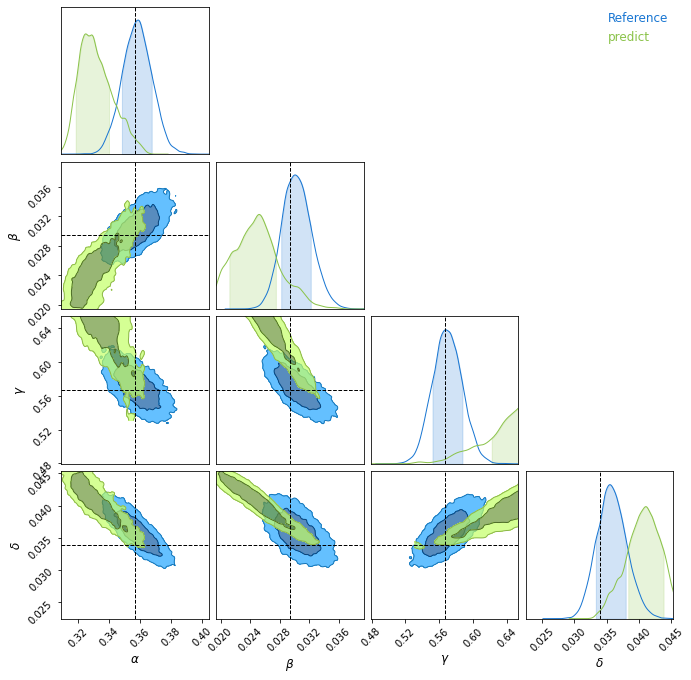

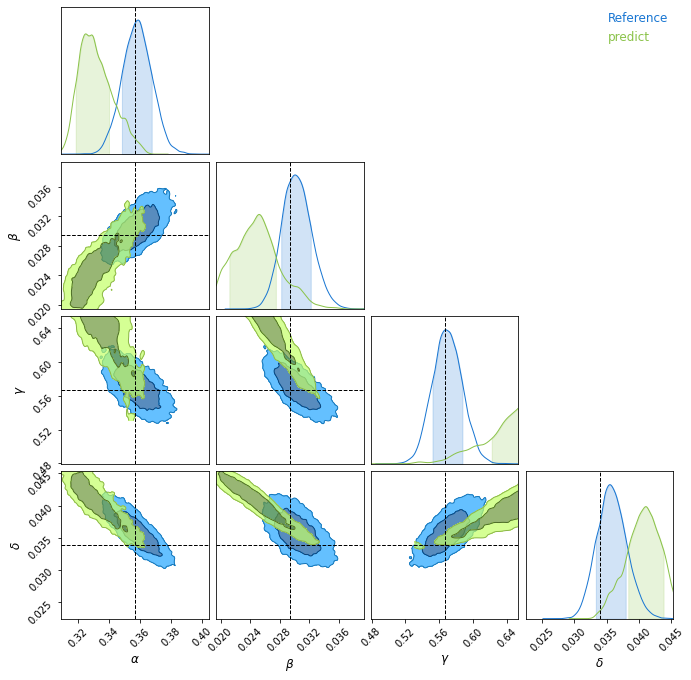

In [13]:
#plot first round
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()
c.add_chain(jnp.array(reference_samples), parameters=parameters, name="Reference")
c.add_chain(sample_for_plot_round_0[0], name="predict")
c.plotter.plot(
    figsize=[10, 10], 
    truth=np.array(truth)[0], 
    extents=[[t - 5 * np.std(reference_samples[:,i]), 
              t + 5 * np.std(reference_samples[:,i])] for i,t in enumerate(truth[0])]
  )

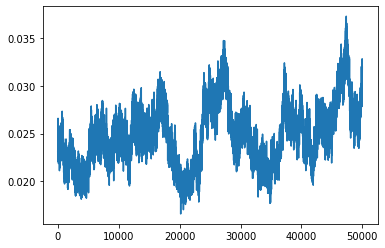

In [14]:
plt.plot(chain_round_0)

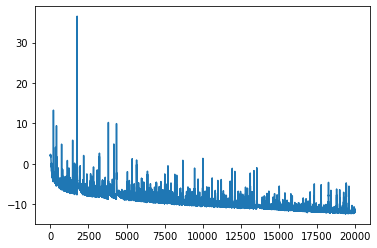

In [15]:
plt.plot(batch_loss_round_0)

In [37]:
model_seed = 0
rounds = 1
score_weight = 0
start_grad = 1
n_simulations_in = 50
n_simulations_out = 50
n_steps = 20000
batch_size = 256

params_nd_round_1_noscore, sample_round_1_noscore, sample_for_plot_round_1_noscore, c2st_metric_round_1_noscore, batch_loss_round_1_noscore, chain_round_1_noscore = inference(sample_round_0,
                                                                                                                                rounds, 
                                                                                                                                score_weight, 
                                                                                                                                n_simulations_in, 
                                                                                                                                n_simulations_out,
                                                                                                                                start_grad, 
                                                                                                                                n_steps,
                                                                                                                                batch_size, 
                                                                                                                                params_nd_round_0)

rounds = 2
params_nd_round_2_noscore, sample_round_2_noscore, sample_for_plot_round_2_noscore, c2st_metric_round_2_noscore, batch_loss_round_2_noscore, chain_round_2_noscore = inference(sample_round_1_noscore,
                                                                                                                                rounds, 
                                                                                                                                score_weight, 
                                                                                                                                n_simulations_in, 
                                                                                                                                n_simulations_out,
                                                                                                                                start_grad, 
                                                                                                                                n_steps,
                                                                                                                                batch_size, 
                                                                                                                                params_nd_round_1_noscore)

[[0.33710998 0.02719103 0.63081545 0.03891249]
 [0.33798322 0.02758634 0.6264663  0.03848628]
 [0.32572263 0.02456558 0.65049064 0.0428062 ]
 [0.3355434  0.02615071 0.6660725  0.03963549]
 [0.31747916 0.02116011 0.71319854 0.04266673]
 [0.3194282  0.01943963 0.7475574  0.04486693]
 [0.33685192 0.02341838 0.6797882  0.04216808]
 [0.32833347 0.02660924 0.6525282  0.03970183]
 [0.33060315 0.02371014 0.72648966 0.04036832]
 [0.32628602 0.02236137 0.70398706 0.0430056 ]
 [0.3307324  0.02845345 0.62104654 0.03786312]
 [0.3184574  0.0202585  0.75387466 0.04368456]
 [0.32427025 0.02370682 0.67738736 0.04244885]
 [0.32179412 0.0219277  0.7301654  0.0419863 ]
 [0.3394126  0.02540524 0.66363376 0.03972211]
 [0.35758212 0.02850606 0.61005574 0.0369961 ]
 [0.32703766 0.02336337 0.67791855 0.04231859]
 [0.32764155 0.02407423 0.6700551  0.04175671]
 [0.33892578 0.02581307 0.65088314 0.0402811 ]
 [0.32212234 0.01986365 0.7589598  0.04493628]
 [0.34345403 0.02197157 0.7360566  0.04127501]
 [0.34356013 

  0%|          | 0/20000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 20000/20000 [14:16<00:00, 23.35it/s]
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will

start mcmc


/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


[[0.32796112 0.02648318 0.61241734 0.03944709]
 [0.32756528 0.03018539 0.59777063 0.04141842]
 [0.33901826 0.02998745 0.5832608  0.03809612]
 [0.34674194 0.02949053 0.5726111  0.03626055]
 [0.34779444 0.02952407 0.5820942  0.03812005]
 [0.36967725 0.03672504 0.5188322  0.03054503]
 [0.37412894 0.02960967 0.55326533 0.03135038]
 [0.36359674 0.02844918 0.57417864 0.0337554 ]
 [0.3544844  0.02872224 0.5540048  0.03519392]
 [0.3426929  0.02947204 0.5989432  0.03828247]
 [0.35368457 0.02938611 0.5771678  0.03475571]
 [0.34781846 0.02919067 0.57581544 0.03680463]
 [0.34881866 0.03135201 0.56817406 0.0363194 ]
 [0.3494753  0.03047342 0.57477546 0.03789496]
 [0.3486932  0.02789753 0.5826441  0.0360528 ]
 [0.3289017  0.02818658 0.6014982  0.04046533]
 [0.3683798  0.03040438 0.5472832  0.03239506]
 [0.37280816 0.03083678 0.5584951  0.03272333]
 [0.334915   0.02712775 0.5935246  0.03930259]
 [0.3910508  0.03116376 0.5449067  0.03117356]
 [0.38149083 0.03117059 0.55403733 0.03148601]
 [0.34972876 

  0%|          | 0/20000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 20000/20000 [15:14<00:00, 21.87it/s]
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will

start mcmc


/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


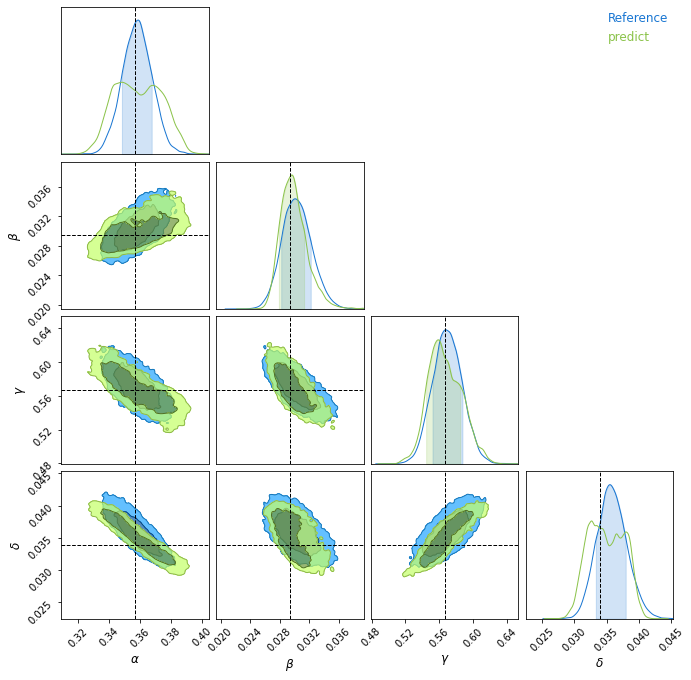

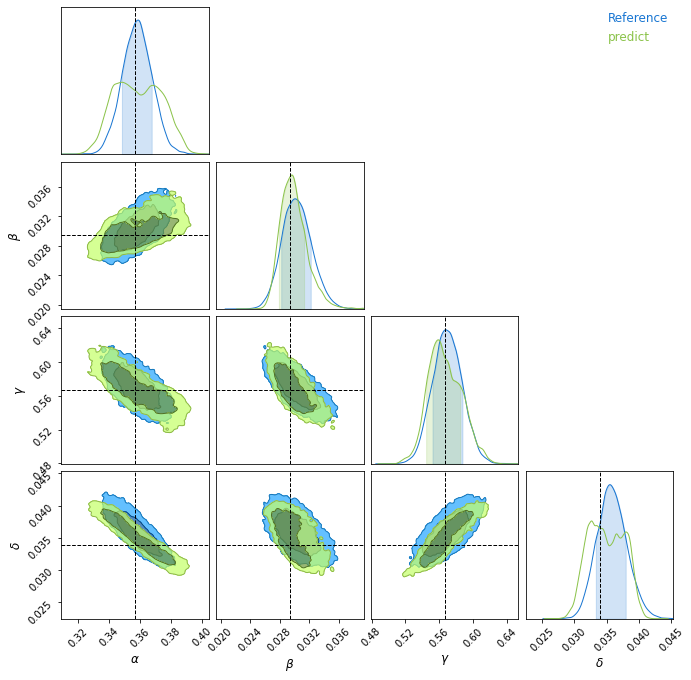

In [38]:
#plot first round
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()
c.add_chain(jnp.array(reference_samples), parameters=parameters, name="Reference")
c.add_chain(sample_for_plot_round_1_noscore[0], name="predict")
c.plotter.plot(
    figsize=[10, 10], 
    truth=np.array(truth)[0], 
    extents=[[t - 5 * np.std(reference_samples[:,i]), 
              t + 5 * np.std(reference_samples[:,i])] for i,t in enumerate(truth[0])]
  )

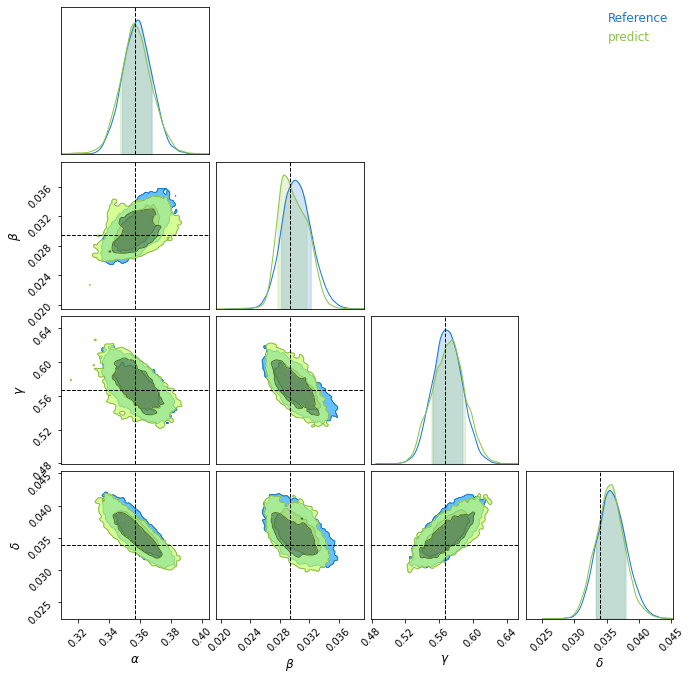

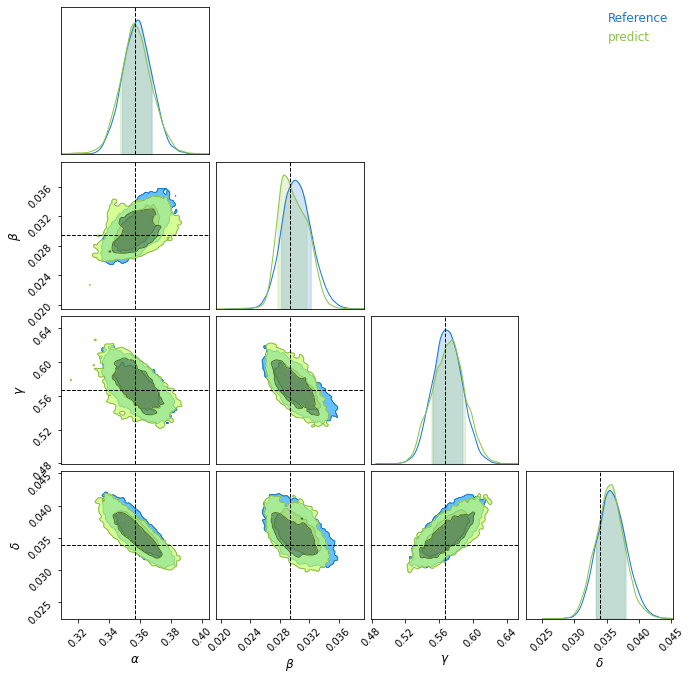

In [39]:
#plot first round
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()
c.add_chain(jnp.array(reference_samples), parameters=parameters, name="Reference")
c.add_chain(sample_for_plot_round_2_noscore[0], name="predict")
c.plotter.plot(
    figsize=[10, 10], 
    truth=np.array(truth)[0], 
    extents=[[t - 5 * np.std(reference_samples[:,i]), 
              t + 5 * np.std(reference_samples[:,i])] for i,t in enumerate(truth[0])]
  )

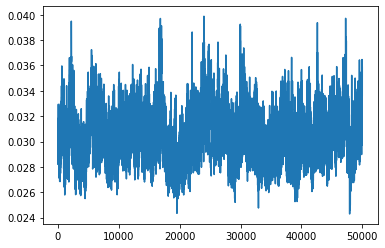

In [40]:
plt.plot(chain_round_1_noscore)

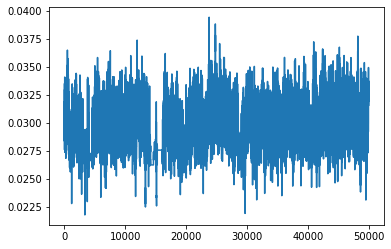

In [42]:
plt.plot(chain_round_2_noscore)

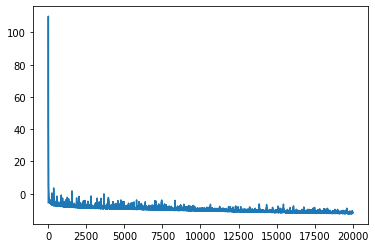

In [41]:
plt.plot(batch_loss_round_1_noscore)

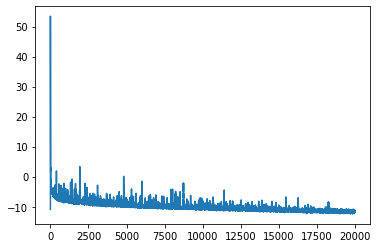

In [43]:
plt.plot(batch_loss_round_2_noscore)

In [44]:
model_seed = 0
rounds = 1
score_weight = 1e-7
start_grad = 1
n_simulations_in = 50
n_simulations_out = 50
n_steps = 20000
batch_size = 256

params_nd_round_1_1e7score, sample_round_1_1e7score, sample_for_plot_round_1_1e7score, c2st_metric_round_1_1e7score, batch_loss_round_1_1e7score, chain_round_1_1e7score = inference(sample_round_0,
                                                                                                                                rounds, 
                                                                                                                                score_weight, 
                                                                                                                                n_simulations_in, 
                                                                                                                                n_simulations_out,
                                                                                                                                start_grad, 
                                                                                                                                n_steps,
                                                                                                                                batch_size, 
                                                                                                                                params_nd_round_0)

rounds = 2
params_nd_round_2_1e7score, sample_round_2_1e7score, sample_for_plot_round_2_1e7score, c2st_metric_round_2_1e7score, batch_loss_round_2_1e7score, chain_round_2_1e7score = inference(sample_round_1_1e7score,
                                                                                                                                rounds, 
                                                                                                                                score_weight, 
                                                                                                                                n_simulations_in, 
                                                                                                                                n_simulations_out,
                                                                                                                                start_grad, 
                                                                                                                                n_steps,
                                                                                                                                batch_size, 
                                                                                                                                params_nd_round_1_1e7score)

/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 20000/20000 [13:47<00:00, 24.17it/s]
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)


start mcmc


/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
/usr/local/lib/python3.7/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


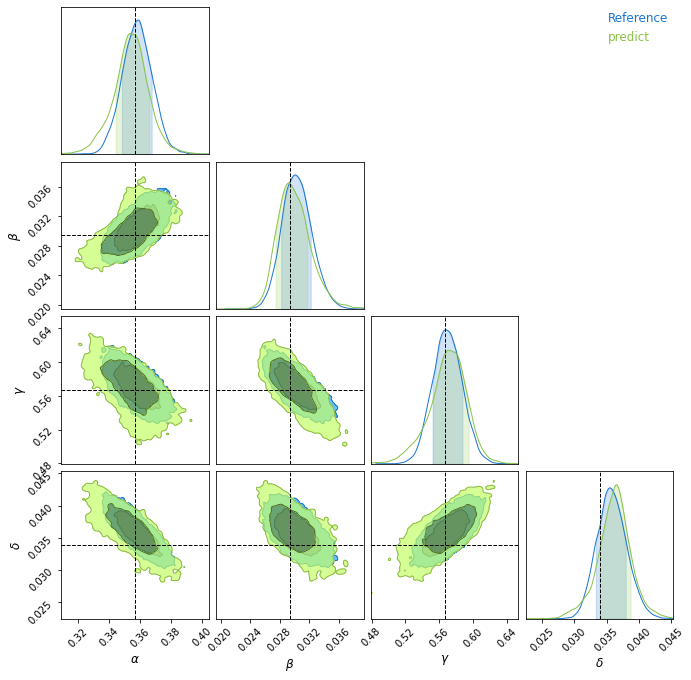

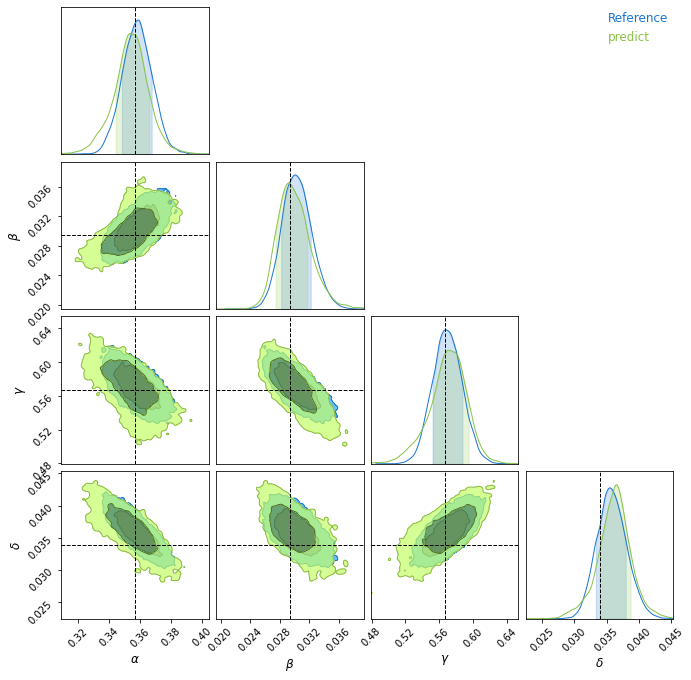

In [48]:
#plot first round
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()
c.add_chain(jnp.array(reference_samples), parameters=parameters, name="Reference")
c.add_chain(sample_for_plot_round_1_1e7score[0], name="predict")
c.plotter.plot(
    figsize=[10, 10], 
    truth=np.array(truth)[0], 
    extents=[[t - 5 * np.std(reference_samples[:,i]), 
              t + 5 * np.std(reference_samples[:,i])] for i,t in enumerate(truth[0])]
  )

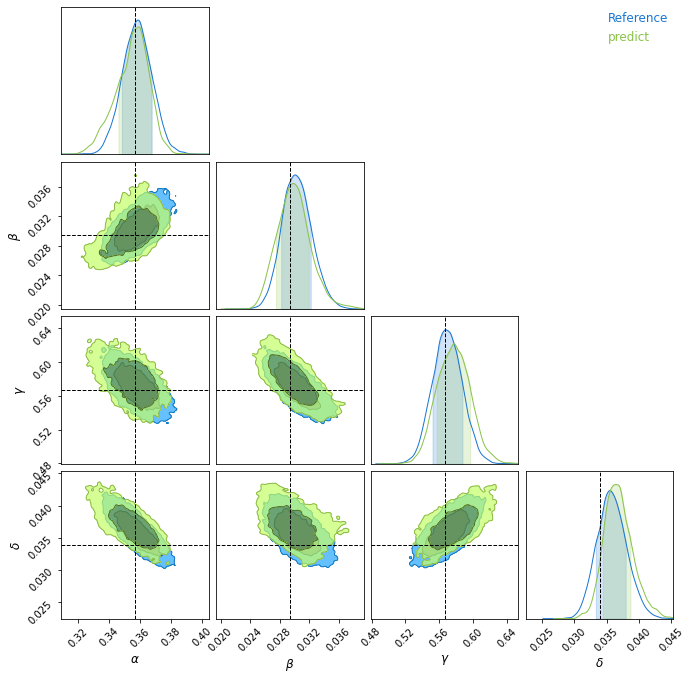

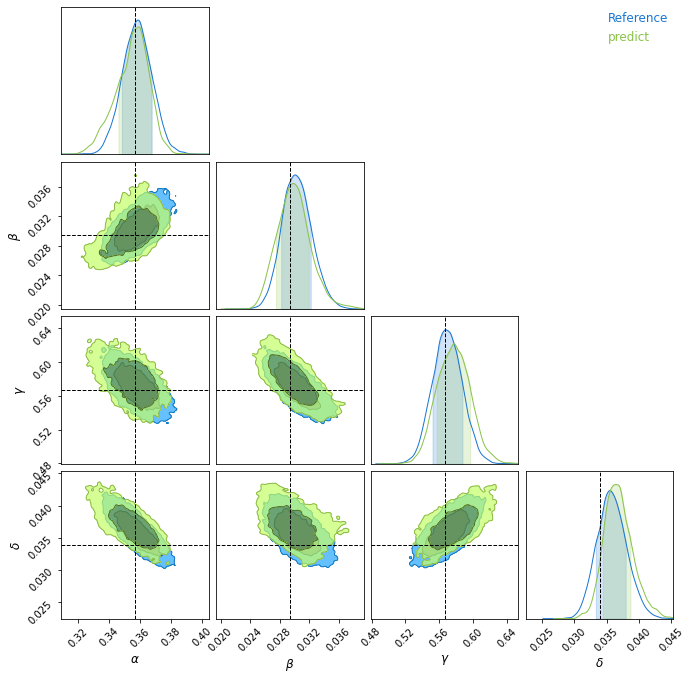

In [50]:
#plot first round
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()
c.add_chain(jnp.array(reference_samples), parameters=parameters, name="Reference")
c.add_chain(sample_for_plot_round_2_1e7score[0], name="predict")
c.plotter.plot(
    figsize=[10, 10], 
    truth=np.array(truth)[0], 
    extents=[[t - 5 * np.std(reference_samples[:,i]), 
              t + 5 * np.std(reference_samples[:,i])] for i,t in enumerate(truth[0])]
  )

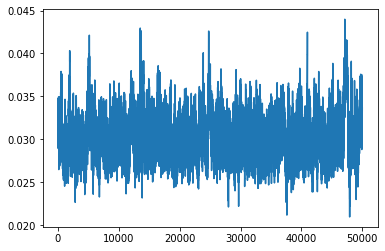

In [51]:
plt.plot(chain_round_1_1e7score)

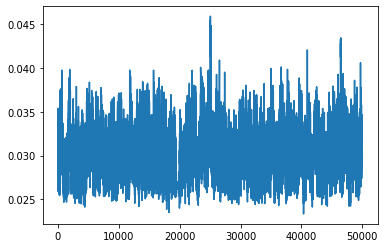

In [53]:
plt.plot(chain_round_2_1e7score)

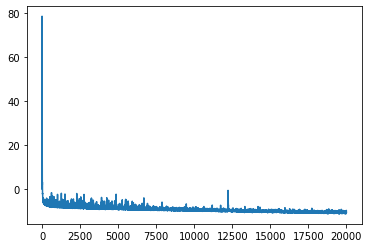

In [54]:
plt.plot(batch_loss_round_1_1e7score)

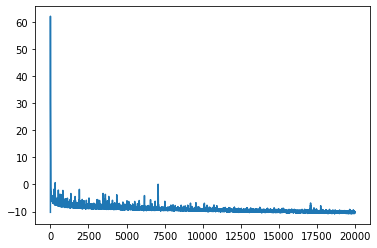

In [55]:
plt.plot(batch_loss_round_2_1e7score)

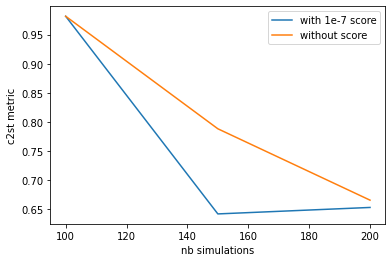

In [61]:
x = [100,150,200]
plt.plot(x, jnp.concatenate([jnp.array(c2st_metric_round_0),
                             jnp.array(c2st_metric_round_1_1e7score), jnp.array(c2st_metric_round_2_1e7score)]), label='with 1e-7 score')
plt.plot(x, jnp.concatenate([jnp.array(c2st_metric_round_0),
                             jnp.array(c2st_metric_round_1_noscore), jnp.array(c2st_metric_round_2_noscore)]), label='without score')
plt.xlabel('nb simulations')
plt.ylabel('c2st metric')
plt.legend()